In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer 
from scipy import stats
import statsmodels.formula.api as smf

from psyfun import io, atlas, spikes, util, plots
from psyfun.config import *

In [2]:
# Load session info
df_sessions = pd.read_parquet(paths['sessions'])  # session info 

In [3]:
df_trajectories = pd.read_csv(paths['trajectories'])
df_sessions = df_sessions.apply(io._get_trajectory_labels, df_trajectories=df_trajectories, axis='columns').copy()
df_sessions = df_sessions.dropna(subset=['t1', 't2'])
df_sessions['trajectory'] = df_sessions.apply(lambda x: '_'.join([str(x['t1']).rstrip('L').rstrip('R'), str(x['t2'])]).rstrip('L').rstrip('R'), axis='columns')

In [4]:
# Load unit info for all units
df_units = pd.read_parquet(paths['units'])  # unit info
df_units['coarse_region'] = atlas.coarse_regions(df_units['region'])  # convert specific anatomical acronym to more coarse parcellation

In [5]:
print(f"Total sessions: {len(df_sessions)}")

# Remove sessions missing timing information for important experimental epochs
task_epochs = ['task00_spontaneous_start', 'task01_spontaneous_start', 'task00_replay_start', 'task01_replay_start']
df_sessions = df_sessions.dropna(subset=task_epochs)


# JA: drop massive outlier from my recordings, this recording should probably be removed from the dataset altogether
# Recording from ZFM-08457 on 2025-03-20, eid: 'e31bff07-d66c-4a03-894d-f71030161ead'
# Notes from recording: No spikes!!! -> SAC!
# To drop the session, run:
# df_sessions = df_sessions[df_sessions['eid'] != 'e31bff07-d66c-4a03-894d-f71030161ead']

print(f"Remaining sessions: {len(df_sessions)}")

Total sessions: 40
Remaining sessions: 35


In [6]:
# Get eids for remaining sessions
eids = df_sessions['eid'].tolist()
df_units = df_units.query('eid in @eids')
print(f"Total units: {len(df_units)}")

# Some useful filters:
unit_filter = 'ks2_label == "good"'  # kilosort label for well-isolated units, as opposed to multi-unit activity (mua)
# unit_filter = 'label == 1.0'  # more conservative IBL quality criterion
# Additional filters can be constructed using any column of the unit metadata
# print(df_units.columns)

# Remove low-quality units
df_units = df_units.query(unit_filter)
print(f"Remaining units: {len(df_units)}")

Total units: 79454
Remaining units: 14886


In [7]:
# Load spike times
df_spiketimes = io.load_units(paths['spikes'], df_units['uuid'])

100%|███████████████████████████████████| 14886/14886 [00:03<00:00, 3786.68it/s]


In [8]:
# Join spike times with unit info
df_spikes = df_units.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessions, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns after merge
df_spikes = df_spikes[[col for col in df_spikes.columns if not col.endswith('_x') or col.endswith('_y')]]

In [9]:
df_spikes['full_start'] = df_spikes[[col for col in df_spikes.columns if '_start' in col]].min(axis='columns')
df_spikes['full_stop'] = df_spikes[[col for col in df_spikes.columns if '_stop' in col]].max(axis='columns')

In [48]:
# Epochs defined by visual stimulation protocol
task_epochs = [  
    'task00_spontaneous', 
    # 'task00_replay',
    'task01_spontaneous', 
    # 'task01_replay'
    'full'
]

# Pick a set of epochs from which we will get spike counts and run PCA
epochs = task_epochs

# Get spike counts for epochs
dt = 1  # seconds
for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    # Convert spike times to spike counts in bins of size dt
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    # Compute mean firing rate from array of spike counts
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())

Getting spike counts for: task00_spontaneous


100%|███████████████████████████████████| 14886/14886 [00:03<00:00, 4614.60it/s]


Getting spike counts for: task01_spontaneous


100%|███████████████████████████████████| 14886/14886 [00:03<00:00, 4925.51it/s]


Getting spike counts for: full


100%|███████████████████████████████████| 14886/14886 [00:05<00:00, 2597.06it/s]


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from ssm.hmm import HMM

In [49]:
var_exp = []
for _, session in df_spikes.groupby('eid'):
    if len(session) < 150:
        continue
    X = np.stack(session['full_counts']).T
    X_norm = StandardScaler().fit_transform(X)
    pca = PCA()
    X_pcs = pca.fit_transform(X_norm) 
    var_exp.append(pca.explained_variance_ratio_)

In [50]:
fig, ax = plt.subplots()
for var in var_exp:
    ax.plot(np.cumsum(var), color='gray', alpha=0.5)

In [73]:
K = 10
D = 100

# for _, session in df_spikes.groupby('eid'):
eid = df_spikes['eid'].unique()[3]
session = df_spikes.query('eid == @eid') 
if len(session) < 150:
    raise
X = np.stack(session['full_counts']).T
X_norm = StandardScaler().fit_transform(X)
pca = PCA(n_components=D)
X_pca = pca.fit_transform(X_norm)
# hmm = HMM(K, D)
# ll = hmm.fit(X_pca)
remodel = GaussianHMM(n_components=10, covariance_type="full", n_iter=100)
remodel.fit(X_pca)
    # break

GaussianHMM(covariance_type='full', n_components=10, n_iter=100)

In [71]:
%matplotlib qt
posterior = hmm.expected_states(X_pca)[0]
fig, axs = plt.subplots(10, sharex=True)
for ax, state_p in zip(axs, posterior.T):
    ax.plot(state_p)
    ax.set_ylim([0, 1])

5


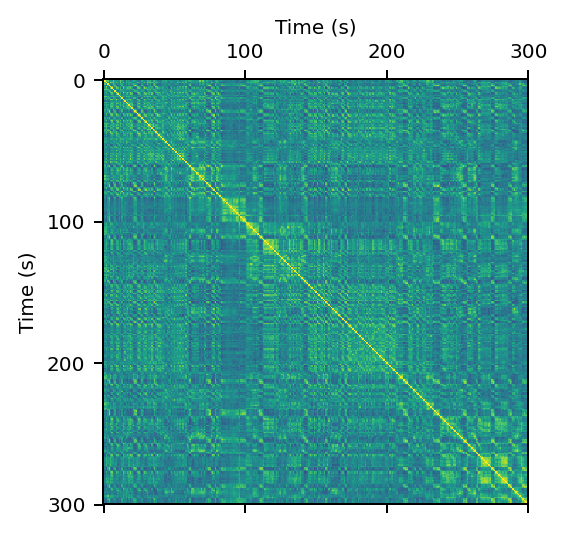

In [25]:
fig, ax = plt.subplots()
X = np.stack(session['task00_spontaneous_counts']).T
X_norm = StandardScaler().fit_transform(X)
pca = PCA(n_components=60)
X_pcs = pca.fit_transform(X_norm) 
D = cosine_similarity(X_pcs)
pca = PCA()
pca.fit(StandardScaler().fit_transform(D))
print(np.cumsum(pca.explained_variance_ratio_).searchsorted(0.8))
ax.matshow(D, vmin=-1, vmax=1)
ax.set_xticks([0, 100, 200, 300])
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Time (s)')
ax.set_yticks([0, 100, 200, 300])
ax.set_ylabel('Time (s)')
plots.set_plotsize(w=6)